# Assignment 3: Flash/No Flash Photography

#### Author: Bora Dere, 2220765021

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import interpolate, signal
import os

In [2]:
CAMERA_FLASH = os.path.join(os.getcwd(), 'data', 'camera', 'flash')
CAMERA_NONFLASH = os.path.join(os.getcwd(), 'data', 'camera', 'nonflash')

FACE_FLASH = os.path.join(os.getcwd(), 'data', 'face', 'flash')
FACE_NONFLASH = os.path.join(os.getcwd(), 'data', 'face', 'nonflash')

In [4]:
camera_flash_image = cv2.imread(os.path.join(CAMERA_FLASH, '1.jpg'))
camera_flash_image = cv2.cvtColor(camera_flash_image, cv2.COLOR_BGR2RGB)
camera_flash_image = camera_flash_image.astype(np.float32) / 255.0

camera_nonflash_image = cv2.imread(os.path.join(CAMERA_NONFLASH, '1.jpg'))
camera_nonflash_image = cv2.cvtColor(camera_nonflash_image, cv2.COLOR_BGR2RGB)
camera_nonflash_image = camera_nonflash_image.astype(np.float32) / 255.0

face_flash_image = cv2.imread(os.path.join(FACE_FLASH, '10.png'))
face_flash_image = cv2.cvtColor(face_flash_image, cv2.COLOR_BGR2RGB)
face_flash_image = face_flash_image.astype(np.float32) / 255.0

face_nonflash_image = cv2.imread(os.path.join(FACE_NONFLASH, '10.png'))
face_nonflash_image = cv2.cvtColor(face_nonflash_image, cv2.COLOR_BGR2RGB)
face_nonflash_image = face_nonflash_image.astype(np.float32) / 255.0

## 1- Bilateral Filtering

In [5]:
def piecewise_bilateral_filter(image, sigma_s, sigma_r, nb_segments=None):
    """
    Implements piecewise bilateral filtering as described in Durand and Dorsey's paper.
    
    Parameters:
    - image: Input image (single channel or color)
    - sigma_s: Standard deviation for the spatial Gaussian kernel
    - sigma_r: Standard deviation for the range/intensity Gaussian kernel
    - nb_segments: Number of segments for piecewise approximation (if None, calculated automatically)
    
    Returns:
    - Filtered image
    """
    
    # Handle color images by processing each channel separately
    if len(image.shape) == 3:
        result = np.zeros_like(image)
        for c in range(image.shape[2]):
            result[:,:,c] = piecewise_bilateral_filter(image[:,:,c], sigma_s, sigma_r, nb_segments)
        return result
    
    # For grayscale images
    lambda_val = 0.01  # Small constant to extend range
    min_val = np.min(image) - lambda_val
    max_val = np.max(image) + lambda_val
    
    # Calculate number of segments if not provided
    if nb_segments is None:
        nb_segments = int(np.ceil((max_val - min_val) / sigma_r))
    
    # Create segments
    segment_values = np.linspace(min_val, max_val, nb_segments)
    
    # Initialize multi-channel image to store results for each segment
    J_segments = np.zeros((image.shape[0], image.shape[1], nb_segments))
    
    # Implementation following pseudocode from the paper
    # J = 0
    result = np.zeros_like(image)
    
    # For each segment
    for j, i_j in enumerate(segment_values):
        # G_j = g_sigma_r(I - i_j)
        G_j = np.exp(-0.5 * ((image - i_j) / sigma_r) ** 2)
        
        # K_j = G_j convolved with f_sigma_s
        K_j = cv2.GaussianBlur(G_j, (0, 0), sigma_s) + 1e-8  # prevent division by zero
        
        # H_j = G_j * I
        H_j = G_j * image
        
        # H'_j = H_j convolved with f_sigma_s
        H_j_prime = cv2.GaussianBlur(H_j, (0, 0), sigma_s)
        
        # J_j = H'_j / K_j (normalized)
        J_j = H_j_prime / K_j
        
        # Store J_j in the multi-channel image
        J_segments[:, :, j] = J_j
    
    # Interpolation step
    # Create grid of coordinates and intensity values for interpolation
    y_coords, x_coords = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    
    # Build the set of points for interpolation
    xi = np.zeros((image.shape[0] * image.shape[1], 3))
    xi[:, 0] = y_coords.flatten()
    xi[:, 1] = x_coords.flatten()
    xi[:, 2] = image.flatten()
    
    # Perform linear interpolation
    output = interpolate.interpn(
        (np.arange(image.shape[0]), np.arange(image.shape[1]), segment_values),
        J_segments,
        xi,
        method='linear',
        bounds_error=False,
        fill_value=None
    )
    
    return output.reshape(image.shape)

### Experimenting

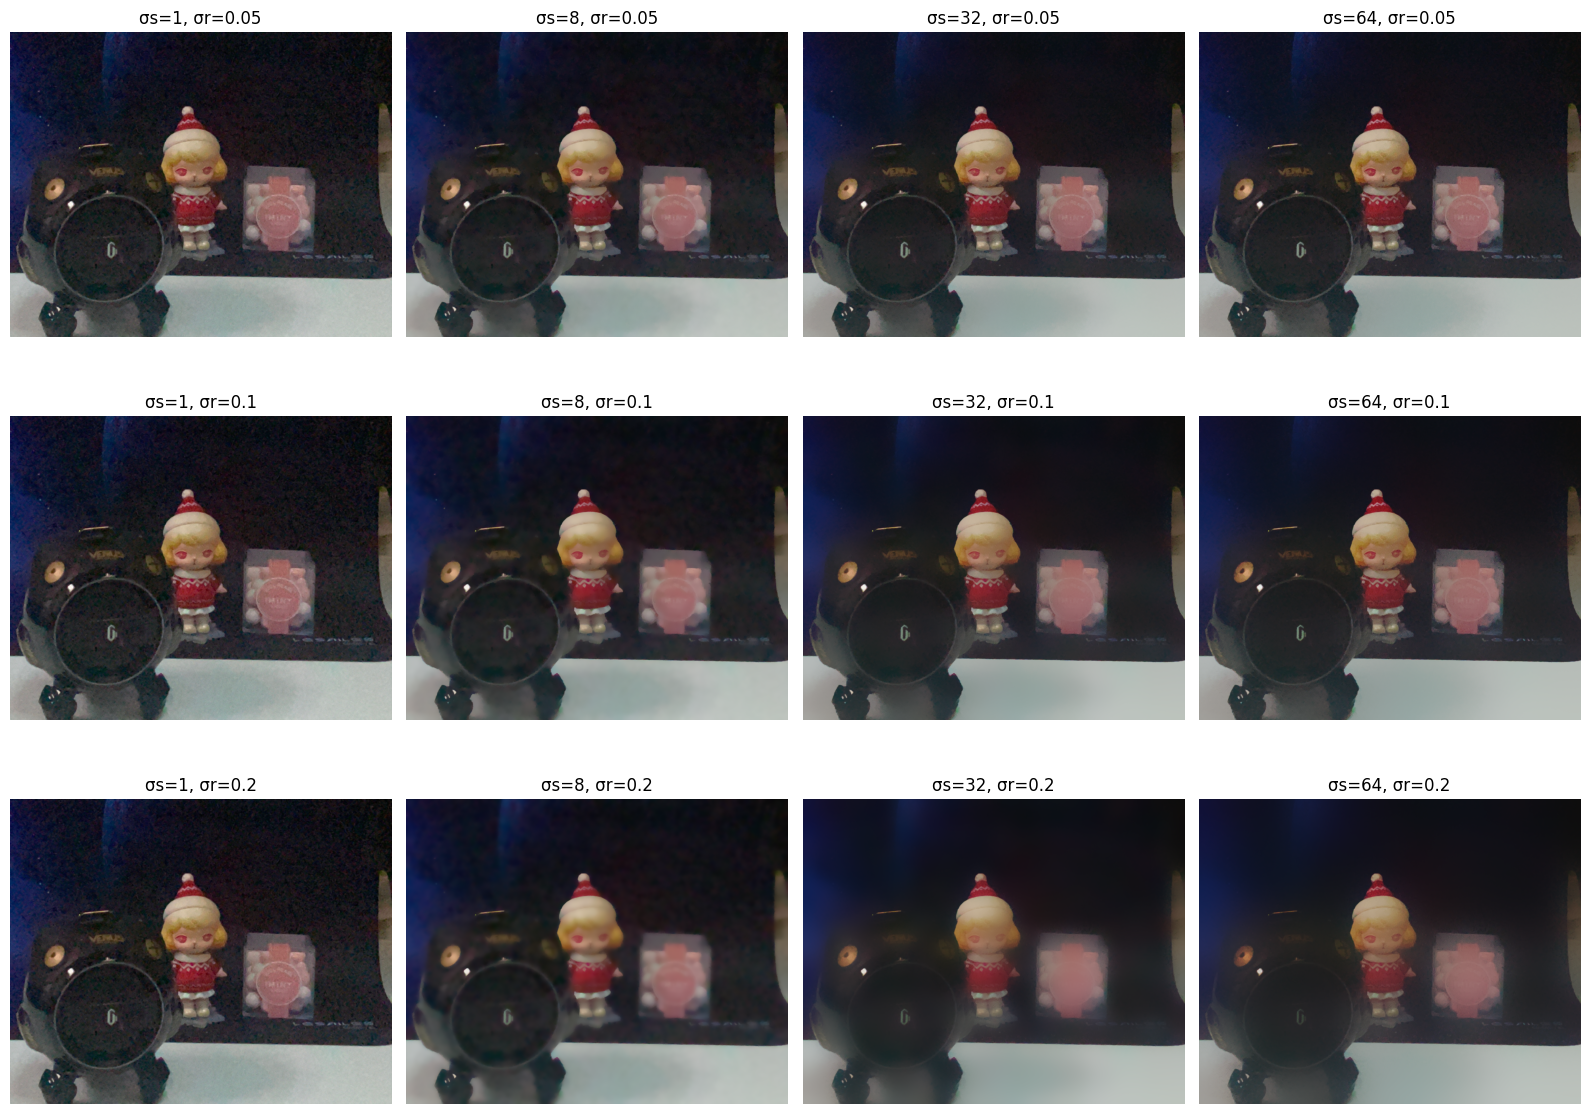

In [ ]:
+

# Create figure for visualization
fig, axes = plt.subplots(len(sigma_r_values), len(sigma_s_values), 
                        figsize=(16, 12))

# Process for each parameter combination
for i, sigma_r in enumerate(sigma_r_values):
    for j, sigma_s in enumerate(sigma_s_values):
        # Apply bilateral filter with current parameters
        filtered = piecewise_bilateral_filter(camera_nonflash_image, sigma_s, sigma_r)
        
        # Display result
        axes[i, j].imshow(filtered)
        axes[i, j].set_title(f'σs={sigma_s}, σr={sigma_r}')
        axes[i, j].axis('off')

# Set overall title
plt.tight_layout()
plt.show()

To me, σs=32, σr=0.1 is good enough. Comparing with the others, it has a good balance of denoising to detail preservation. It still does not contain much of a detail but it is far better than the others. 

### Joint-Bilateral Filtering

In [8]:
def joint_bilateral_filter(ambient_img, flash_img, sigma_s, sigma_r, nb_segments=None):
    """
    Implements joint bilateral filtering as described in Petschnigg et al.
    Uses flash image for edge detection but filters the ambient image.
    
    Parameters:
    - ambient_img: Ambient (no-flash) image to be filtered
    - flash_img: Flash image used for edge detection
    - sigma_s: Standard deviation for the spatial Gaussian kernel
    - sigma_r: Standard deviation for the range/intensity Gaussian kernel
    - nb_segments: Number of segments for piecewise approximation
    
    Returns:
    - Noise-reduced ambient image (A_NR)
    """
    
    # Handle color images by processing each channel separately
    if len(ambient_img.shape) == 3:
        result = np.zeros_like(ambient_img)
        
        # For color images, we should use the same flash reference for all channels
        # Convert to luminance if it's a color image
        if len(flash_img.shape) == 3:
            # Use luminance (simple average) for edge detection
            flash_guide = np.mean(flash_img, axis=2)
        else:
            flash_guide = flash_img
            
        for c in range(ambient_img.shape[2]):
            result[:,:,c] = joint_bilateral_filter(
                ambient_img[:,:,c], 
                flash_guide, 
                sigma_s, 
                sigma_r, 
                nb_segments
            )
        return result
    
    # For grayscale images
    # Define range of intensity values for segmentation
    lambda_val = 0.01
    min_val = np.min(flash_img) - lambda_val
    max_val = np.max(flash_img) + lambda_val
    
    # Calculate number of segments if not provided
    if nb_segments is None:
        nb_segments = int(np.ceil((max_val - min_val) / sigma_r))
    
    # Create segments
    segment_values = np.linspace(min_val, max_val, nb_segments)
    
    # Initialize multi-channel image to store results for each segment
    J_segments = np.zeros((ambient_img.shape[0], ambient_img.shape[1], nb_segments))
    
    # Adaptation of piecewise bilateral filtering for joint bilateral filtering
    for j, i_j in enumerate(segment_values):
        # G_j uses flash image for edge detection, but we're filtering ambient image
        # g_r(Fp - Fp') in the paper's notation
        G_j = np.exp(-0.5 * ((flash_img - i_j) / sigma_r) ** 2)
        
        # K_j = G_j convolved with f_sigma_s
        K_j = cv2.GaussianBlur(G_j, (0, 0), sigma_s) + 1e-8
        
        # H_j = G_j * A (using ambient image for the actual values)
        H_j = G_j * ambient_img
        
        # H'_j = H_j convolved with f_sigma_s
        H_j_prime = cv2.GaussianBlur(H_j, (0, 0), sigma_s)
        
        # J_j = H'_j / K_j (normalized)
        J_j = H_j_prime / K_j
        
        # Store J_j in the multi-channel image
        J_segments[:, :, j] = J_j
    
    # Interpolation step
    # Create grid of coordinates and intensity values for interpolation
    y_coords, x_coords = np.mgrid[0:flash_img.shape[0], 0:flash_img.shape[1]]
    
    # Build the set of points for interpolation
    xi = np.zeros((flash_img.shape[0] * flash_img.shape[1], 3))
    xi[:, 0] = y_coords.flatten()
    xi[:, 1] = x_coords.flatten()
    xi[:, 2] = flash_img.flatten()  # Use flash values for interpolation indices
    
    # Perform linear interpolation
    output = interpolate.interpn(
        (np.arange(flash_img.shape[0]), np.arange(flash_img.shape[1]), segment_values),
        J_segments,
        xi,
        method='linear',
        bounds_error=False,
        fill_value=None
    )
    
    return output.reshape(ambient_img.shape)

### Experimenting

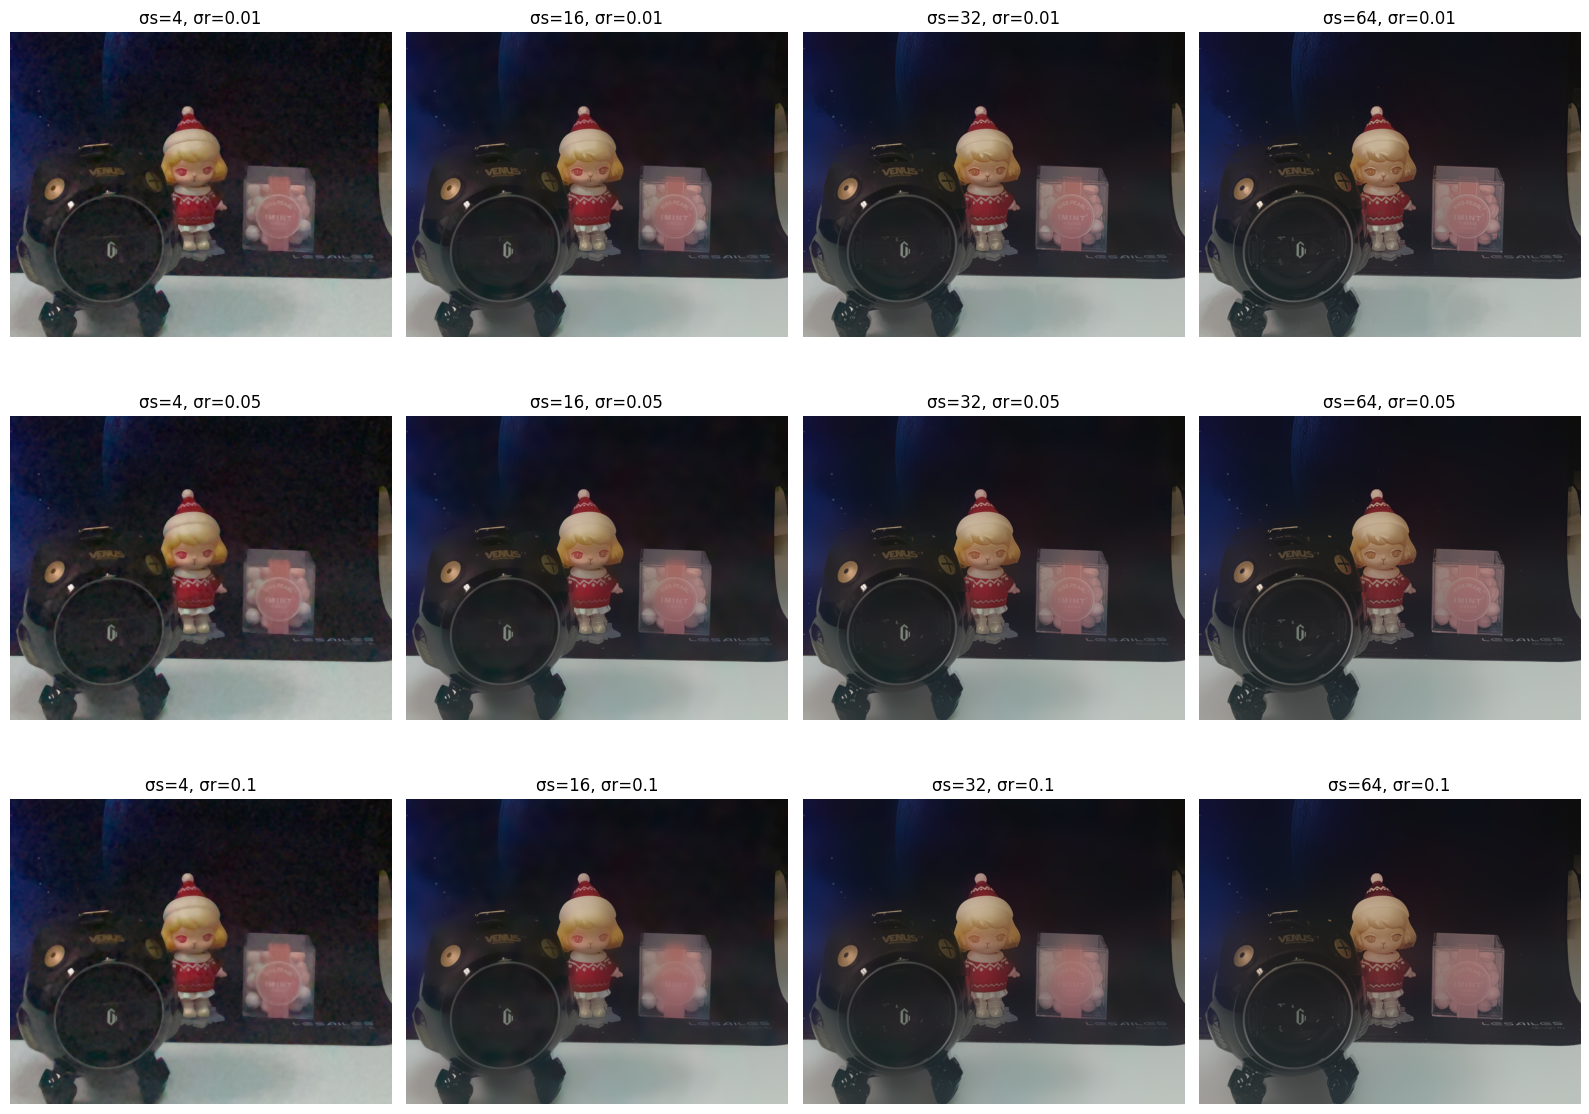

In [9]:
# Experiment with different parameters for joint bilateral filtering
sigma_s_values = [4, 16, 32, 64]  # Spatial sigma
sigma_r_values = [0.01, 0.05, 0.1]  # Range sigma (smaller values as recommended)

# Create figure for visualization
fig, axes = plt.subplots(len(sigma_r_values), len(sigma_s_values), 
                        figsize=(16, 12))

# Process for each parameter combination
for i, sigma_r in enumerate(sigma_r_values):
    for j, sigma_s in enumerate(sigma_s_values):
        # Apply joint bilateral filter
        filtered = joint_bilateral_filter(camera_nonflash_image, camera_flash_image, sigma_s, sigma_r)
        
        # Display result
        axes[i, j].imshow(filtered)
        axes[i, j].set_title(f'σs={sigma_s}, σr={sigma_r}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()